In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium import plugins
import json
from branca.colormap import LinearColormap

In [2]:
data = pd.read_csv('data\survey_data.csv',low_memory=False)
measles_data = pd.read_excel('data\measles_data.xlsx')

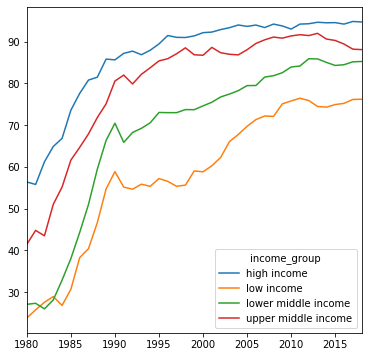

In [3]:
#plot measles coverage by income
measles_data.groupby('income_group').mean().T.plot(figsize=(6,6))

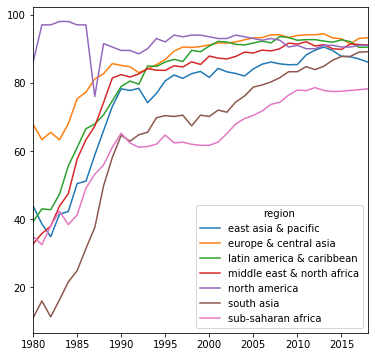

In [4]:
#plot measles coverage by region
measles_data.groupby('region').mean().T.plot(figsize=(6,6))

In [5]:
vaccine_safety = data[['id', 'age', 'age_category', 'gender', 'education', 'employment_status',
       'household_income', 'subjective_income', 'geography', 'region',
       'country', 'country_code', 'country_income','Q25']].copy()

In [6]:
s_agree = vaccine_safety['Q25'] == '1'
agree = vaccine_safety['Q25'] == '0.75'
neither = vaccine_safety['Q25'] == '0.5'
disagree = vaccine_safety['Q25'] == '0.25'
s_disagree = vaccine_safety['Q25'] == '0'

In [7]:
v_safe = vaccine_safety[s_agree].shape[0]
safe = vaccine_safety[agree].shape[0]
neither = vaccine_safety[neither].shape[0]
unsafe = vaccine_safety[disagree].shape[0]
v_unsafe = vaccine_safety[s_disagree].shape[0]

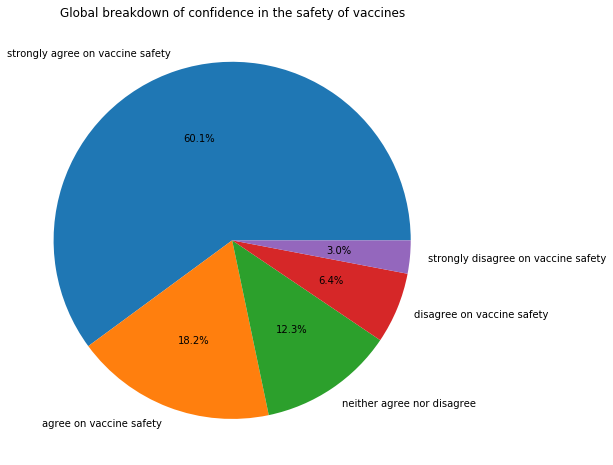

In [8]:
labels = ['strongly agree on vaccine safety', 'agree on vaccine safety', 'neither agree nor disagree', 'disagree on vaccine safety','strongly disagree on vaccine safety']
sizes = [v_safe, safe, neither, unsafe,v_unsafe]

plt.figure(figsize=(8,8))
plt.axis('equal')
plt.pie(sizes,labels=labels,autopct='%1.1f%%')
plt.title('Global breakdown of confidence in the safety of vaccines')
plt.show()

In [9]:
def vaxConfident(x):
    if x == '0.75' or x == '1':
        return 'Y'
    elif x == '0.5' or x == '0.25' or x == '0':
        return 'N'
    else:
        return 'no_response'
    
vaccine_safety['confident'] = vaccine_safety['Q25'].apply(lambda x:vaxConfident(x))

In [10]:
val_safe = vaccine_safety['confident'] == 'Y'
val_unsafe = vaccine_safety['confident'] == 'N'

safe_dict = dict(zip(vaccine_safety[val_safe].groupby('country_code').count().index,vaccine_safety[val_safe].groupby('country_code').count()['id']))
unsafe_dict = dict(zip(vaccine_safety[val_unsafe].groupby('country_code').count().index,vaccine_safety[val_unsafe].groupby('country_code').count()['id']))

In [11]:
df = pd.DataFrame({'country_code':list(safe_dict.keys()),'num_safe':list(safe_dict.values())})
df['num_unsafe'] = df['country_code'].apply(lambda x:unsafe_dict.get(x))

country_dict = dict(zip(data['country_code'],data['country']))
df['country'] = df['country_code'].apply(lambda x:country_dict.get(x))

measles_dict = dict(zip(measles_data['country_code'],measles_data[2018]))
df['perc_measles_vaccinated_2018'] = df['country_code'].apply(lambda x:measles_dict.get(x))

df['perc_safe'] = (df['num_safe']/(df['num_safe']+df['num_unsafe']))*100

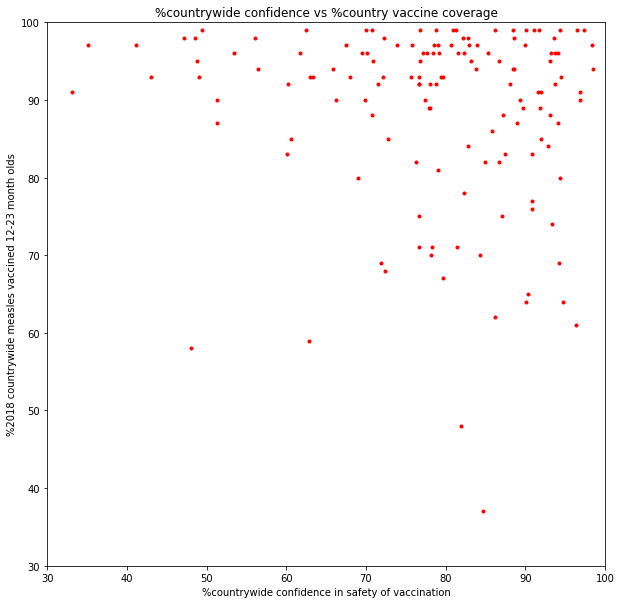

In [12]:
plt.figure(figsize=(10,10))
plt.scatter(df['perc_safe'],df['perc_measles_vaccinated_2018'],marker='.',color='r')
plt.xlim((30,100)),plt.ylim((30,100))
plt.title('%countrywide confidence vs %country vaccine coverage')
plt.xlabel('%countrywide confidence in safety of vaccination')
plt.ylabel('%2018 countrywide measles vaccined 12-23 month olds')
plt.show()

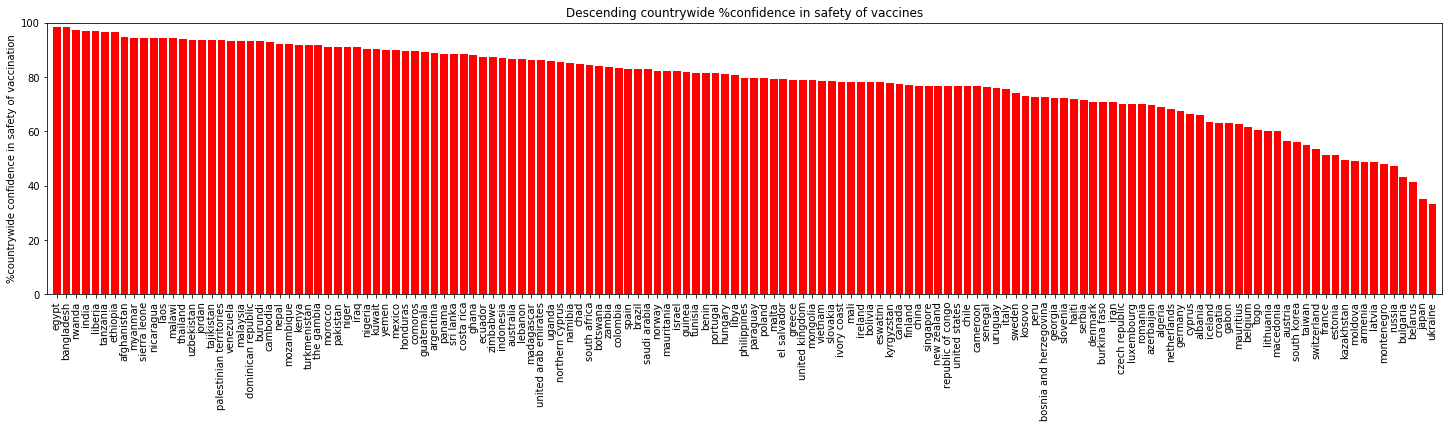

In [13]:
bar_safety = df.sort_values(by='perc_safe',ascending=False)

x_pos = np.arange(len(bar_safety['country']))
y_axis = bar_safety['perc_safe']
plt.figure(figsize=(25,5))
plt.bar(x_pos, y_axis, align='center',color='r')
plt.xticks(x_pos, bar_safety['country'], rotation='vertical')
plt.ylabel('%countrywide confidence in safety of vaccination')
plt.axis([-1, 143, 0,100])
plt.title('Descending countrywide %confidence in safety of vaccines')
plt.show()

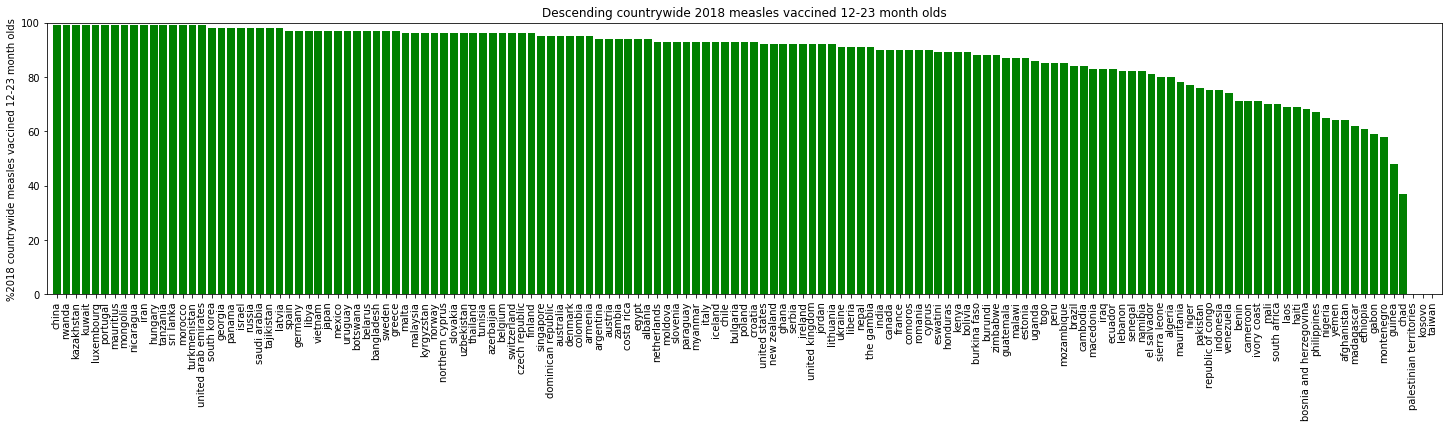

In [14]:
bar_coverage = df.sort_values(by='perc_measles_vaccinated_2018',ascending=False)

x_pos = np.arange(len(bar_coverage['country']))
y_axis = bar_coverage['perc_measles_vaccinated_2018']
plt.figure(figsize=(25,5))
plt.bar(x_pos, y_axis, align='center',color='g')
plt.xticks(x_pos, bar_coverage['country'], rotation='vertical')
plt.ylabel('%2018 countrywide measles vaccined 12-23 month olds')
plt.axis([-1, 143, 0,100])
plt.title('Descending countrywide 2018 measles vaccined 12-23 month olds')
plt.show()

In [15]:
#render a folium world map

geo_world = json.load(open(r'data\folium_raw.json'))
viz_df = pd.read_json(r'data\folium_raw.json')

viz_df['code'] = viz_df['features'].apply(lambda x:x.get('id'))

#define dictionary of country code and country-level data field
viz_dict = dict(zip(df['country_code'],df['perc_safe']))
viz_df['viz_field'] = viz_df['code'].apply(lambda x:viz_dict.get(x))
#set all na values to zero
viz_df['viz_field'] = viz_df['viz_field'].fillna(float('nan'))

In [16]:
m = folium.Map(location=[0, -102], zoom_start=2)

folium.Choropleth(
    geo_data=geo_world,
    name='viz_df',
    data=viz_df,
    columns=['code', 'viz_field'],
    key_on='feature.id',
    fill_color='YlGn',
    nan_fill_color='gray',
    nan_fill_opacity=0.4,
    fill_opacity=0.7,
    line_opacity=0.2,
    #set legend
    legend_name='%2018 countrywide measles vaccined 12-23 month olds'
).add_to(m)

folium.LayerControl().add_to(m)

m